In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [218]:
import json
import ast
import itertools
import os
import argparse
import pickle

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')
sns.set()

from shared_astro_utils import plotting_utils

from zoobot.estimators import input_utils
from zoobot.active_learning import metrics, simulation_timeline, analysis

from zoobot.tfrecord import read_tfrecord
from zoobot.tests import TEST_FIGURE_DIR

In [219]:
!pwd

/Data/repos/zoobot/notebooks


### Define Records to Load

In [220]:
shard_dir = '/Volumes/alpha/uint8_128px_bar_n'

In [260]:
oracle = pd.read_csv(
    os.path.join(shard_dir, 'oracle.csv'), 
    usecols=['id_str', 'label'],
    dtype={'id_str': str, 'label': int}
)

In [265]:
catalog = pd.read_csv('../data/basic_regression_labels_with_bars.csv')
catalog['id_str'] = catalog['id'].astype(str)
catalog['file_loc'] = catalog['png_loc']
catalog['label'] = catalog['t03_bar_a06_bar_count']

In [262]:
catalog.columns.values

array(['dr7objid', 'ra_subject', 'dec_subject', 'total_classifications',
       'total_votes', 't01_smooth_or_features_a01_smooth_count',
       't01_smooth_or_features_a01_smooth_weighted_fraction',
       't01_smooth_or_features_a02_features_or_disk_count',
       't01_smooth_or_features_a02_features_or_disk_weighted_fraction',
       't01_smooth_or_features_a03_star_or_artifact_count',
       't01_smooth_or_features_a03_star_or_artifact_weighted_fraction',
       't02_edgeon_a04_yes_count', 't02_edgeon_a04_yes_weighted_fraction',
       't02_edgeon_a05_no_count', 't02_edgeon_a05_no_weighted_fraction',
       't03_bar_a06_bar_count', 't03_bar_a06_bar_weighted_fraction',
       't03_bar_a07_no_bar_count', 't03_bar_a07_no_bar_weighted_fraction',
       't04_spiral_a08_spiral_count',
       't04_spiral_a08_spiral_weighted_fraction',
       't04_spiral_a09_no_spiral_count',
       't04_spiral_a09_no_spiral_weighted_fraction',
       't07_rounded_a16_completely_round_count',
       't07_r

In [222]:
training_loc = os.path.join(shard_dir, 'train_shards/s128_shard_0.tfrecord')

In [223]:
iteration_dir = '../data/runs/al_baseline_test/iteration_1'
tfrecord_dir = os.path.join(iteration_dir, 'acquired_tfrecords')
acquired_locs = [os.path.join(tfrecord_dir, loc) for loc in os.listdir(tfrecord_dir)]

### Check that labels are recorded correctly, measured via id_strs and catalog

In [ ]:
_ = analysis.verify_tfrecord_matches_catalog(training_loc, catalog)
_ = analysis.verify_tfrecord_matches_catalog(acquired_locs, catalog)

### Load subjects from all records

In [245]:
size = 128
channels = 3
n_subjects = 1024

training_subjects = read_tfrecord.load_examples_from_tfrecord(
    training_loc, 
    read_tfrecord.custom_feature_spec(['matrix', 'id_str', 'label', 'count']),
    n_examples=n_subjects)
training_images = np.array([subject['matrix'].astype(np.uint8).reshape(size, size, channels) for subject in training_subjects])

acquired_subjects = read_tfrecord.load_examples_from_tfrecord(
    acquired_locs, 
    read_tfrecord.custom_feature_spec(['matrix', 'id_str', 'label', 'count']),
    n_examples=n_subjects)
acquired_images = np.array([subject['matrix'].astype(np.uint8).reshape(size, size, channels) for subject in acquired_subjects])

### Visualise Subjects From All Records

In [255]:
n_rows = 6
n_cols = 6
label_strs = ['k: {}, N: {}, ID: {}'.format(s['label'], s['total_votes'], s['id_str'].decode('utf-8')) for s in subjects]

plotting_utils.plot_galaxy_grid(training_images, n_rows, n_cols, 'grid_training.png', labels=label_strs)
plotting_utils.plot_galaxy_grid(acquired_images, n_rows, n_cols, 'grid_acquired.png', labels=label_strs)

In [ ]:
bad_id = '164147'
matching = catalog[catalog['id_str'] == bad_id]
matching

### Compare Distributions of Labels, Total Votes

In [247]:
def unpack(subjects):
    labels = [s['label'] for s in subjects]
    total_votes = [s['total_votes'] for s in subjects]
    id_strs = [s['id_str'].decode('utf-8') for s in subjects]
    return labels, total_votes, id_strs

In [248]:
training_labels, training_total_votes, training_id_strs = unpack(training_subjects)
acquired_labels, acquired_total_votes, acquired_id_strs = unpack(acquired_subjects)

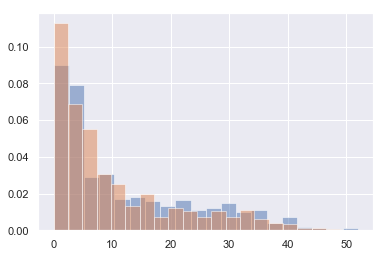

In [249]:
fig, ax = plt.subplots()
ax.hist(training_labels, bins=20, density=True, alpha=0.5)
_ = ax.hist(acquired_labels, bins=20, density=True, alpha=0.5)

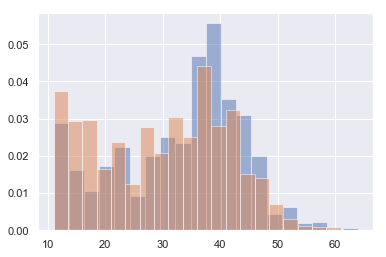

In [250]:
fig, ax = plt.subplots()
ax.hist(training_total_votes, bins=20, density=True, alpha=0.5)
_ = ax.hist(acquired_total_votes, bins=20, density=True, alpha=0.5)

### Check There Are No Duplicates

In [251]:
# no duplicates within train, or within acquired
assert len(training_id_strs) == len(set(training_id_strs))
assert len(acquired_id_strs) == len(set(acquired_id_strs))
# no duplicates shared between training and acquired
assert set(training_id_strs) - set(acquired_id_strs) == set(training_id_strs)
assert set(acquired_id_strs) - set(training_id_strs) == set(acquired_id_strs)

### Check Dimensions and Values of Images are Similar

In [252]:
training_images.shape, acquired_images.shape

((1024, 128, 128, 3), (1024, 128, 128, 3))

In [253]:
training_images.mean(), acquired_images.mean()

(10.191450794537863, 9.530143876870474)

(array([796., 516., 413., 328., 282., 249., 189., 163., 132.,  80.,  53.,
         44.,  28.,  16.,  15.,  10.,   7.,   3.,   4.,   2.]),
 array([ 20007. ,  30008.7,  40010.4,  50012.1,  60013.8,  70015.5,
         80017.2,  90018.9, 100020.6, 110022.3, 120024. , 130025.7,
        140027.4, 150029.1, 160030.8, 170032.5, 180034.2, 190035.9,
        200037.6, 210039.3, 220041. ]),
 <a list of 20 Patch objects>)

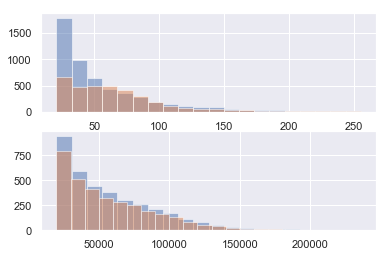

In [254]:
fig, (ax0, ax1) = plt.subplots(nrows=2)
flat_training_image = np.ravel(training_images[0])
ax0.hist(flat_training_image[flat_training_image > 20], bins=20, alpha=0.5)
flat_acquired_image = np.ravel(acquired_images[0])
ax0.hist(flat_acquired_image[flat_acquired_image > 20], bins=20, alpha=0.5)

flat_training_batch = np.ravel(np.sum(training_images, axis=0))
ax1.hist(flat_training_batch[flat_training_batch > 20000], bins=20, alpha=0.5)
flat_acquired_batch = np.ravel(np.sum(acquired_images, axis=0))
ax1.hist(flat_acquired_batch[flat_acquired_batch > 20000], bins=20, alpha=0.5)